# 批量归一化之Pytorch代码实现
## 问题的提出
### 神经网络特别深的时候面临的问题
- 损失出现在最后，后面训练的层训练较快
- 数据在最底部
    - 底部的层训练较慢
    - 底部层一变化，所有都得跟着变
    - 顶部的那些层（深）需要重新多次学习
    - 导致收敛变慢

### 是否有方法避免学习底部层时顶部层的变化？
- 固定小批量里面的均值和方差  
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202261409372.png)

## 批量归一化
- 可学习的参数就是γ和β
- 作用范围：
    - 全连接层和卷积层输出上，激活函数前
    - 全连接层和卷积层输入上
- 对于全连接层，作用在特征维
- 对于卷积层，作用在通道维

## 批量归一化在做什么？
- 最初论文是想用它来减少内部协变量转移
- 后续有论文提出它可能就是通过在每个小批量里加入噪音来控制模型复杂度  
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202261422001.png)
- 认为上述代码中的小批量均值和方差是一个随机的偏移和缩放
- 因此没必要和丢弃法(Dropout)混合使用

## 总结
- 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
- 可以加速收敛速度，但一般不改变模型精度

## 从零实现BN层
### 定义BatchNorm函数

In [5]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

### 定义BN层

In [6]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 使用BN层的LeNet

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

验证模型和训练模型的函数定义

In [8]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y=y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

def train(net, train_iter, test_iter, num_epochs, lr ,device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

训练和评估模型

loss 0.258, train acc 0.904, test acc 0.891
17405.9 examples/sec on cuda:0


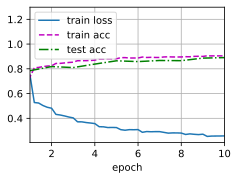

In [9]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 查看BN层中学到的γ和β

In [10]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.0551, 3.1338, 2.4425, 2.7053, 2.9474, 4.2168], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([ 2.1593,  0.7497,  2.4724, -2.9080,  2.0037, -2.5111], device='cuda:0',
        grad_fn=<ViewBackward>))

## 调用API

In [11]:
net1 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.269, train acc 0.900, test acc 0.830
26862.8 examples/sec on cuda:0


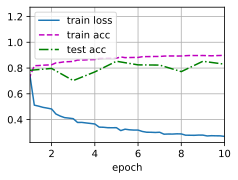

In [12]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train(net1, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())